# Assignment 02

In [1]:
from random import seed,randrange
from csv import reader
import numpy as np
from math import sqrt
import copy
import matplotlib.pyplot as plt 

class_lookup = {'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}

dataset = list()
file_address = 'iris.data'
with open(file_address, 'r') as file:
    contents = reader(file)
    for line in contents:
        if not line:
            continue
        for i in range(len(line)-1):
            line[i] = float(line[i])
        line[-1] = class_lookup[line[-1]]
        dataset.append(line)

print('Size of original set:', len(dataset))

Size of original set: 150


## a. Divide Dataset

In [2]:
seed(1)

dev_data = []
test_data = []
dev_size = len(dataset)//2

for _ in range(dev_size):
    random_index = randrange(len(dataset))
    dev_data.append(dataset.pop(random_index))

test_data = dataset
print('Size of development set:', len(dev_data))
print('Size of test set:', len(test_data))

Size of development set: 75
Size of test set: 75


## b. Implement KNN (Function Definition)

In [3]:
# *Seems do not need to normalize data before using normalized euclidean distance.
# def normalize(data): 
#     data_normalize = copy.deepcopy(data)
#     data_normalize_transpose = list(zip(*data_normalize))
#     for i, row in enumerate(data_normalize_transpose):
#         mean_value = sum(row)/len(row)
#         std_value = sqrt(sum([(x-mean_value)**2 for x in row]) / (len(row) - 1))
#         for j in range(len(row)):
#             data_normalize[j][i] = (data_normalize_transpose[i][j]-mean_value)/std_value    
#     return data_normalize


# Calculate standard deviation for every feature
def calculate_std(data):
    std_list = []
    data_transpose = list(zip(*data))
    for row in data_transpose:
        mean_value = sum(row)/len(row)
        std_value = sqrt(sum([(x-mean_value)**2 for x in row]) / (len(row)-1))
        std_list.append(std_value)
    return std_list

def distance_calculate(distance_metric, node1_index, node2_index, data, std_list):
    # IMPORTANT! The range must -1! Last value is the class label value!
    if distance_metric == 0: # Use euclidean distance
        lst=[(data[node1_index][i]-data[node2_index][i])**2 for i in range(len(data[node1_index])-1)]  #-1 or not -1? **
        return sqrt(sum(lst))
    elif distance_metric == 1:  # Use normalized euclidean distance----d(x,y)=√(∑(xi-yi)^2/si^2)
        return sqrt(sum([(data[node1_index][i]-data[node2_index][i])**2 /std_list[i]**2 for i in range(len(data[node1_index])-1)]))
#         return sqrt(sum([(data_normalize[node1_index][i]-data_normalize[node2_index][i])**2 \
#             for i in range(len(data_normalize[node1_index])-1)]))
    elif distance_metric == 2: # Use cosine similarity
        molecule = sum([data[node1_index][i]*data[node2_index][i] for i in range(len(data[node1_index])-1)])
        denominator = sqrt(sum([x**2 for x in data[node1_index][:-1]])) * sqrt(sum([x**2 for x in data[node2_index][:-1]]))
        return 1-molecule/denominator
        
# Apply KNN and calculate the accuracy
def knn(data, dev_std_list, k, distance_metric):
    correct_count = 0
    for index, node in enumerate(data):
        distance = []
        for index2, node2 in enumerate(data):
            if index == index2:
                distance.append(float('inf'))  # set the similarity to itself as maximum for excluding it from the nearest neighbors list
                continue
            distance.append(distance_calculate(distance_metric, index, index2, data, dev_std_list))
        sorted_index = np.argsort(np.array(distance))
        nearest_nodes = [data[i] for i in sorted_index]
        class_count = {} # key:classlabel, value:count
        for n in nearest_nodes[:k]:
            if n[-1] not in class_count:
                class_count[n[-1]] = 1
            else:
                class_count[n[-1]] += 1
        max_count = 0
        max_label = 0
        for key,value in class_count.items():
            if value > max_count:
                max_count = value
                max_label = key
        if max_label == node[-1]:
            correct_count += 1
    return correct_count / len(data)

## c. Calculate Accuracy and Draw Charts

In [4]:
accuracy_list= []
k = [1,3,5,7]
distance_metric_list = [0,1,2]
distance_metric_lookup = {0: 'Euclidean', 1: 'Normalized Euclidean', 2:'Cosine'}
dev_std_list = calculate_std(dev_data)
for di in distance_metric_list:
    for ki in k:
        accuracy = knn(dev_data, dev_std_list, ki, di)
        accuracy_list.append([di, ki, accuracy])
for x in accuracy_list:
    print('%s distance,  k=%d,  accuracy=%.4f'%(distance_metric_lookup[x[0]], x[1], x[2]))

Euclidean distance,  k=1,  accuracy=0.9467
Euclidean distance,  k=3,  accuracy=0.9600
Euclidean distance,  k=5,  accuracy=0.9333
Euclidean distance,  k=7,  accuracy=0.9467
Normalized Euclidean distance,  k=1,  accuracy=0.9200
Normalized Euclidean distance,  k=3,  accuracy=0.9333
Normalized Euclidean distance,  k=5,  accuracy=0.9600
Normalized Euclidean distance,  k=7,  accuracy=0.9733
Cosine distance,  k=1,  accuracy=0.9600
Cosine distance,  k=3,  accuracy=0.9867
Cosine distance,  k=5,  accuracy=0.9733
Cosine distance,  k=7,  accuracy=0.9733


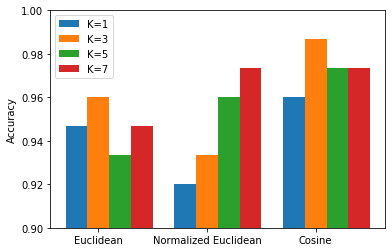

In [5]:
bar_width = 0.2
labels = distance_metric_lookup.values()

for i, ki in enumerate(k):
    plt.bar(np.arange(len(labels))+i*bar_width, [x[2] for x in accuracy_list if x[1]==ki], width=bar_width, label='K='+str(ki))

plt.xticks(np.arange(len(labels))+bar_width, labels)

plt.ylabel('Accuracy')

plt.legend()
plt.ylim(0.9,1)
plt.show()

#### From the chart above, the optimal hyperparameters are k=3 and cosine distance.

## d. Apply in Test Dataset

In [6]:
test_std_list = calculate_std(test_data)
accuracy = knn(test_data, test_std_list,3, 2) # k=3, distance metric=2(Cosine Distance)
print('Accuracy: ', accuracy)

Accuracy:  0.9733333333333334
